In [1]:
import json
import os
from dotenv import load_dotenv
load_dotenv()
import random
import nltk
import re
import heapq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.extmath import cartesian
from sklearn import svm
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [12]:
class DataProcessor:
    # TODO: Make this explanation better
    # Milliseconds between messages under which we consider messages be a single message
    CONCAT_THRESHOLD = int(os.getenv("CONCAT_THRESHOLD"))

    def __init__(self, simulacrum_name):
        # The full name of the recipient as shown in the various message_X.json files
        self.simulacrum_name = simulacrum_name
        self.sent = []
        self.received = []
        self.pairs = []
        self.sent_vector = []
        self.received_vector = []
        self.vocabulary_size = 0
        self.vocabulary = []
        try:
            nltk.data.find('tokenizers/punkt')
        except LookupError:
            nltk.download('punkt')

    def extract(self):
        disallowed_list = ["You are now connected on Messenger.", "http", "www.", "@", "You joined the video chat.",
                           "joined the video chat."]
        path = os.getcwd() + "/data/messages/inbox/"
        conversations = []
        # for file_name in [file for file in os.listdir(path) if file.endswith('.json')]:
        for (dirpath, folder, file) in os.walk(path):
            if len(file) > 0 and file[0].endswith('.json'):
                for message in file:
                    conversations.append(dirpath + "/" + message)
        for conversation in conversations:
            with open(conversation) as json_file:
                data = json.load(json_file)
                last_timestamp = 0
                last_sender = ""
                for message in data["messages"]:
                    if "content" in message and not any(
                            disallowed in message["content"] for disallowed in disallowed_list) and message[
                        "type"] == "Generic":
                        if self.simulacrum_name == message["sender_name"]:
                            if len(self.sent) != 0 and last_timestamp - message[
                                "timestamp_ms"] < DataProcessor.CONCAT_THRESHOLD and last_sender == self.simulacrum_name:
                                self.sent[-1] = message["content"] + " " + self.sent[-1]
                            else:
                                self.sent.append(message["content"])
                        else:
                            if len(self.received) != 0 and message["sender_name"] == last_sender and last_timestamp - \
                                    message["timestamp_ms"] < DataProcessor.CONCAT_THRESHOLD:
                                self.received[-1] = message["content"] + " " + self.received[-1]
                            else:
                                self.received.append(message["content"])
                        if last_sender == self.simulacrum_name and message["sender_name"] != self.simulacrum_name:
                            self.pairs.append((len(self.sent) - 1, len(self.received) - 1))
                        last_sender = message["sender_name"]
                        last_timestamp = message["timestamp_ms"]

        self.sent = self.clean_sentences(self.sent)
        self.received = self.clean_sentences(self.received)
        return self

    def clean_sentences(self, sentences):
        for i in range(len(sentences)):
            sentences[i] = sentences[i].lower()
            sentences[i] = re.sub(r'\W', ' ', sentences[i])
            sentences[i] = re.sub(r'\s+', ' ', sentences[i])
        return sentences

    def create_vocabulary(self, sentences):
        wordfreq = {}
        for sentence in sentences:
            tokens = nltk.word_tokenize(sentence)
            for token in tokens:
                if token not in wordfreq.keys():
                    wordfreq[token] = 1
                else:
                    wordfreq[token] += 1
        #             Put number of words in ENV later
        return heapq.nlargest(400, wordfreq, key=wordfreq.get)

    def create_sentence_vectors(self, sentences, vocabulary):
        sentence_vectors = []
        for sentence in sentences:
            sentence_tokens = nltk.word_tokenize(sentence)
            sent_vec = []
            for token in vocabulary:
                if token in sentence_tokens:
                    sent_vec.append(1)
                else:
                    sent_vec.append(0)
            sentence_vectors.append(sent_vec)
        return np.asarray(sentence_vectors)

    def process(self):
        self.extract()
        self.vocabulary = self.create_vocabulary(self.sent)
        self.vocabulary_size = len(self.vocabulary)
        self.sent_vector = self.create_sentence_vectors(self.sent, self.vocabulary)
        self.received_vector = self.create_sentence_vectors(self.received, self.vocabulary)
        X = self.sent_vector
        y = np.full(shape=len(self.sent_vector), fill_value=1, dtype=np.int)
        X = np.concatenate((X, self.received_vector))
        y = np.concatenate((y, np.full(shape=len(self.received_vector), fill_value=0, dtype=np.int)))
        self.X = X
        self.y = y
        print("Processed")
        return self

    def get_random_pair(self):
        temp = random.randint(0, len(self.pairs) - 1)
        print(temp)
        x, y = self.pairs[random.randint(0, temp)]
        print(self.received[y])
        print(self.sent[x])

    def getData(self):
        return train_test_split(self.X, self.y, test_size=0.5)

    def processData(self, sentence):
        return self.create_sentence_vectors([sentence], self.vocabulary)


processor = DataProcessor(os.getenv("SIMULACRUM_NAME")).process()
train_X, test_X, train_y, test_y = processor.getData()

Processed


In [3]:
scaled_X = StandardScaler().fit(train_X)

In [13]:
RF = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=0)
RF.fit(train_X, train_y)

print(round(RF.score(test_X, test_y), 4))

0.618


In [5]:
def makeNewSentence(vocabulary, num):
    output = vocabulary
    for i in range(num):
        print(i)
        output += list(' '.join(e) for e in itertools.product(output, vocabulary))
    print(output)

In [6]:
NN = MLPClassifier(random_state=0)
NN.fit(train_X, train_y)
print(round(NN.score(test_X,test_y), 4))

/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6145


In [7]:
SVM = svm.LinearSVC(max_iter=2000)
SVM.fit(train_X, train_y)
print(round(SVM.score(test_X,test_y), 4))

0.6417


In [8]:
results = SVM.predict(test_X)

In [9]:
makeNewSentence(processor.vocabulary, 1)
# sentences = processor.create_sentence_vectors(itertools.permutations(processor.vocabulary, 2), processor.vocabulary)
# test_sentence = RF.predict(sentences)
# print(test_sentence)

0
['i', 'the', 'you', 'to', 'it', 'a', 'is', 'and', 'that', 't', 'like', 'my', 'for', 's', 'in', 'so', 'but', 'of', 'this', 'can', 'we', 'me', 'have', 'are', 'no', 'what', 'do', 'not', 'am', 'was', 'xa', 'just', 'at', 'be', 'on', 'if', 'm', 'get', 'there', 'shit', 'one', 'all', 'with', 'don', 'know', 'need', 'he', 'or', '3', 'na', 'then', 'now', 'will', 'how', 'ok', 'up', 'll', 'your', 'go', 'did', 'good', 'time', 'fuck', 'when', 'well', 'they', 'as', 'see', 'u', 'got', 'lol', 'oh', 'also', 'gon', 'fucking', 'right', 'because', '2', 'want', 'num', 'out', 'thing', 'make', 'would', 'why', 'an', 'about', 'wait', 'p', 'think', 'has', 'class', 'from', 'sure', 'work', 'going', 'even', 'where', 'game', 'more', 'who', 'only', 'still', 'its', '1', 'home', 'done', 'never', 'she', 'here', 'yeah', 'david', 'day', '5', 'play', 'things', 'tomorrow', 'had', 'yes', 'same', 'too', 'them', 'guys', 'dude', 'by', 'down', 'actually', 'say', 'mean', 'really', 'today', 'yea', 'back', 'already', 'wtf', 'first

In [10]:
print(len(test_X[results==1]))
performance = sum(test_X[results==1])

33961


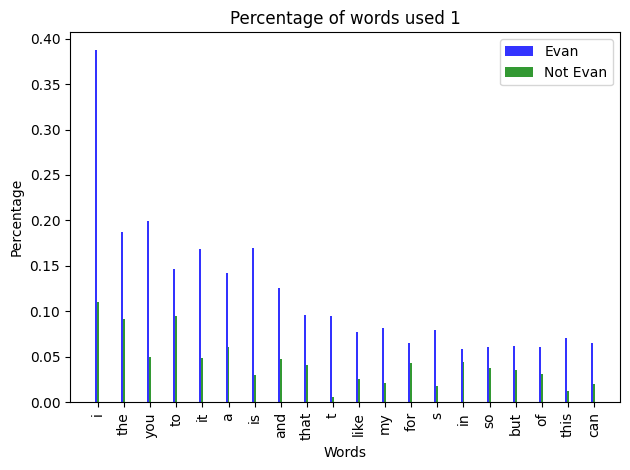

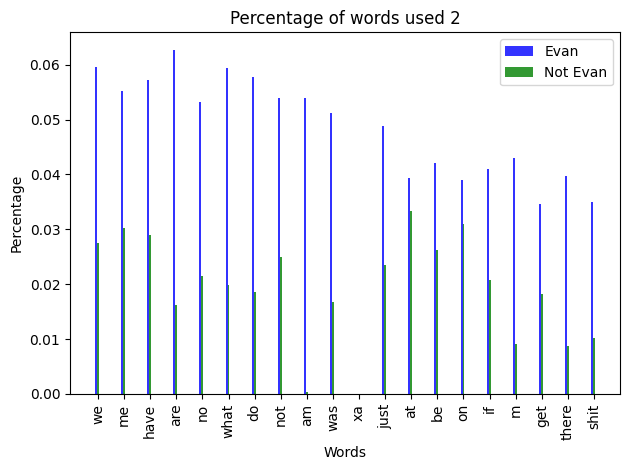

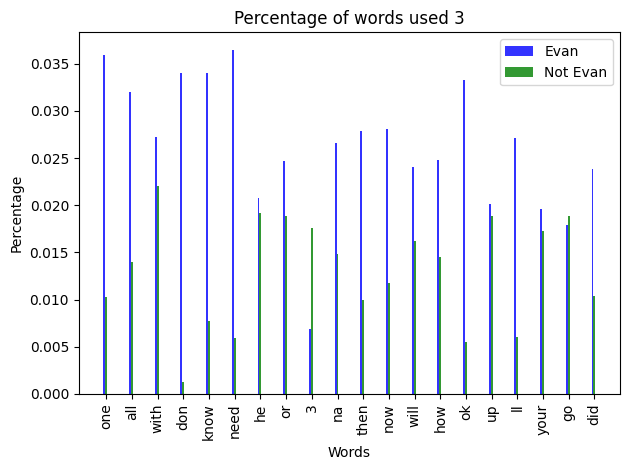

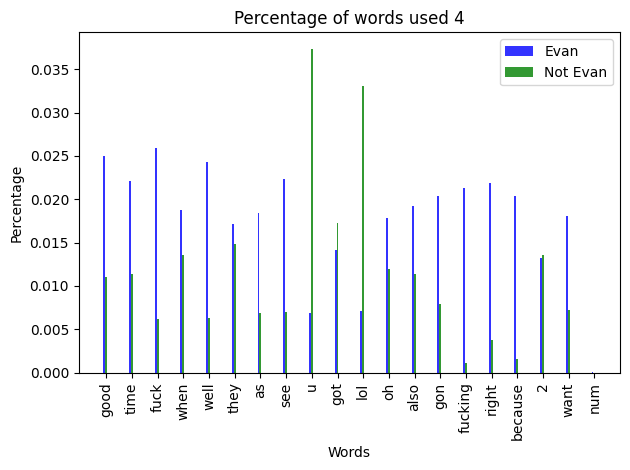

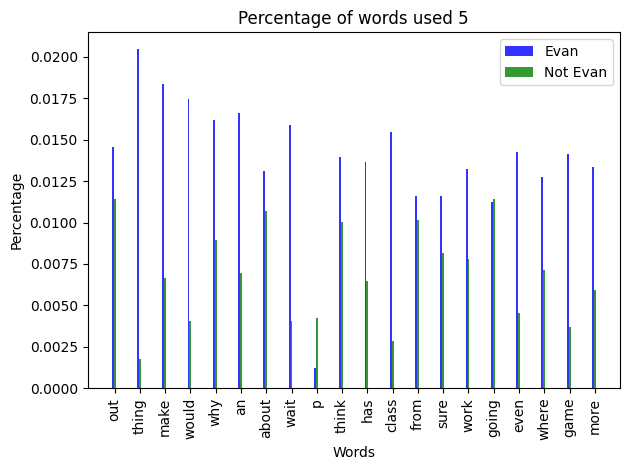

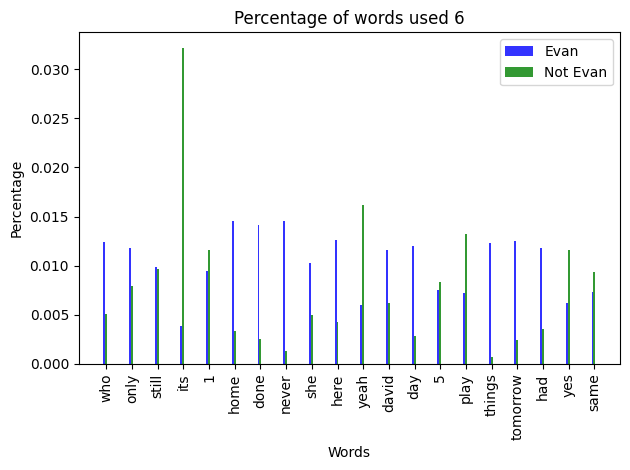

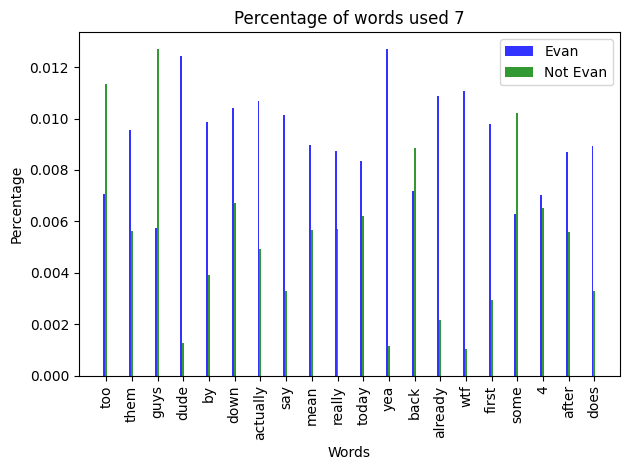

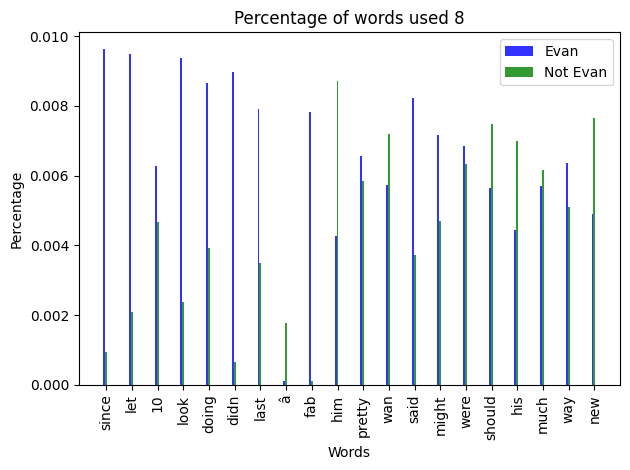

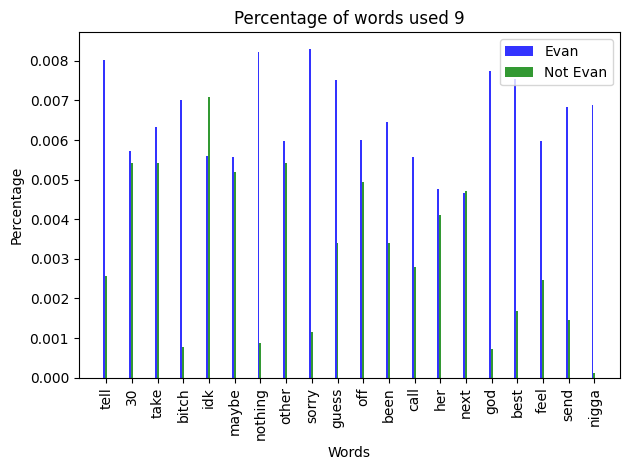

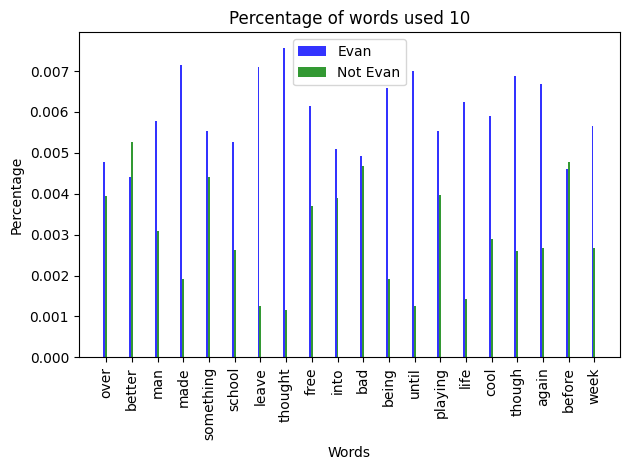

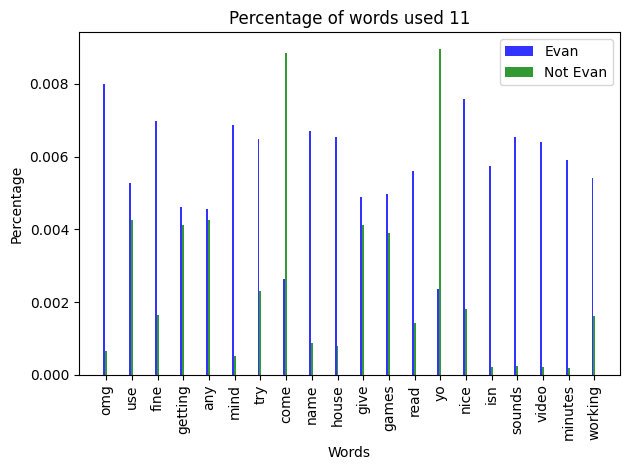

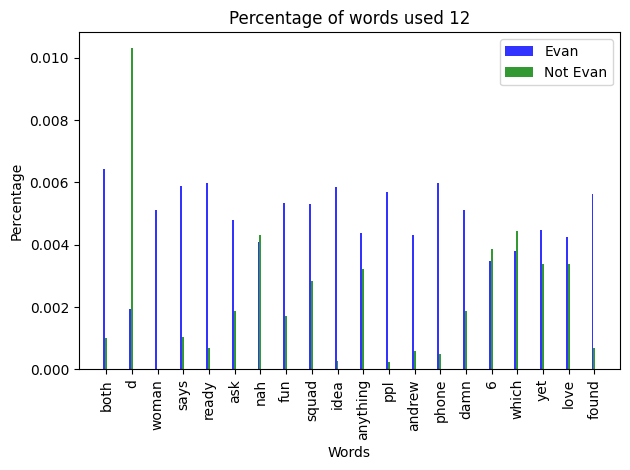

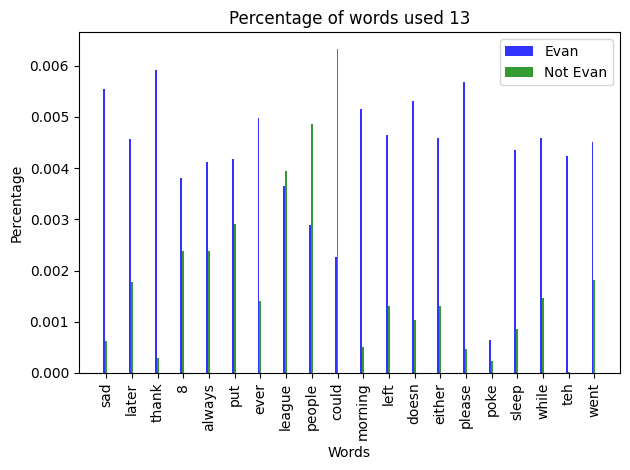

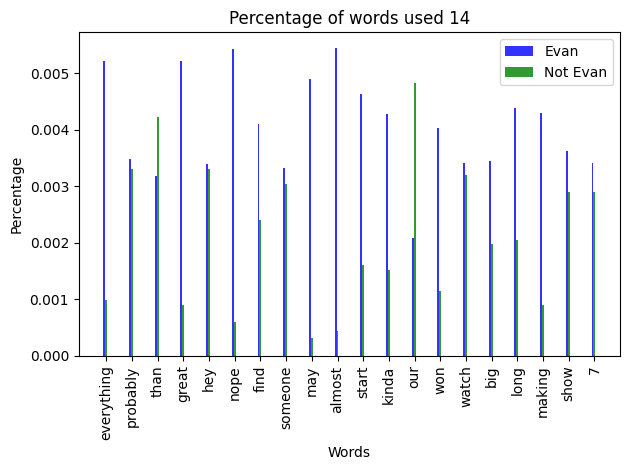

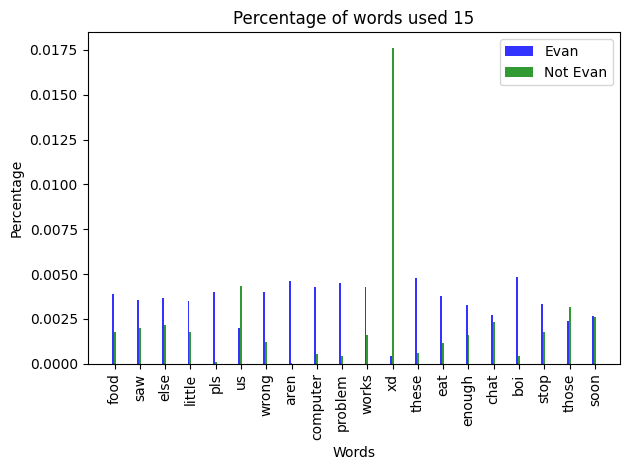

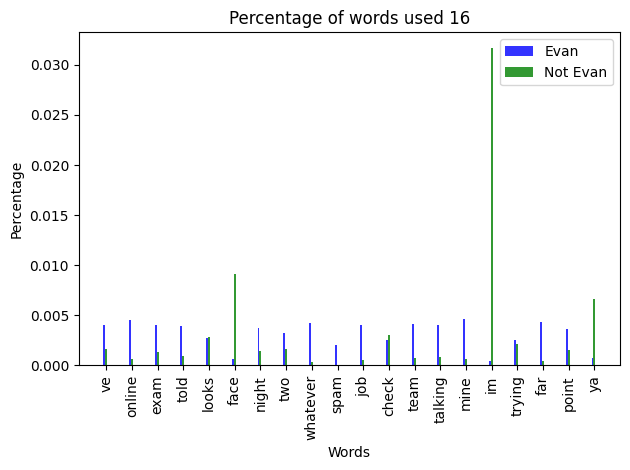

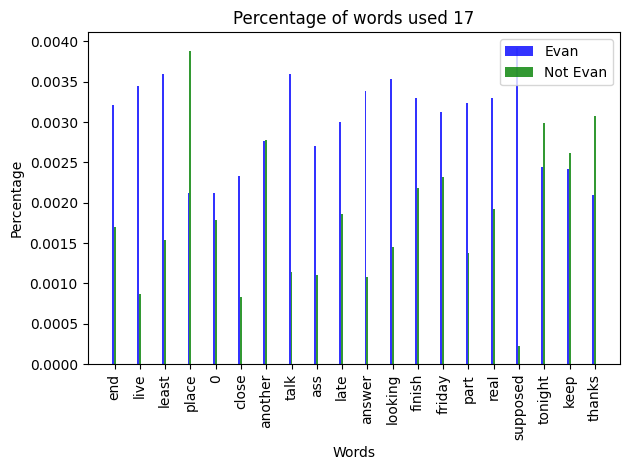

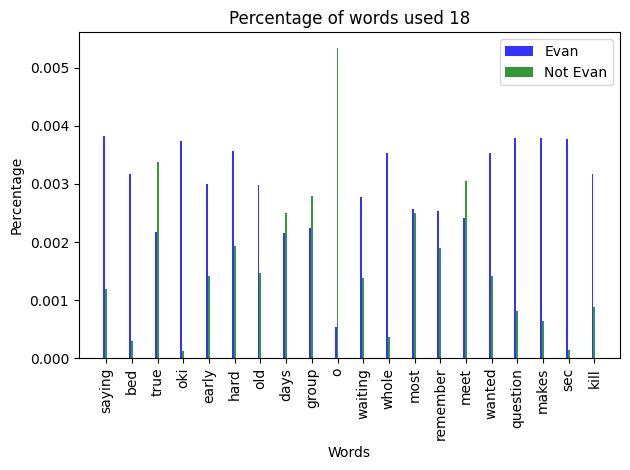

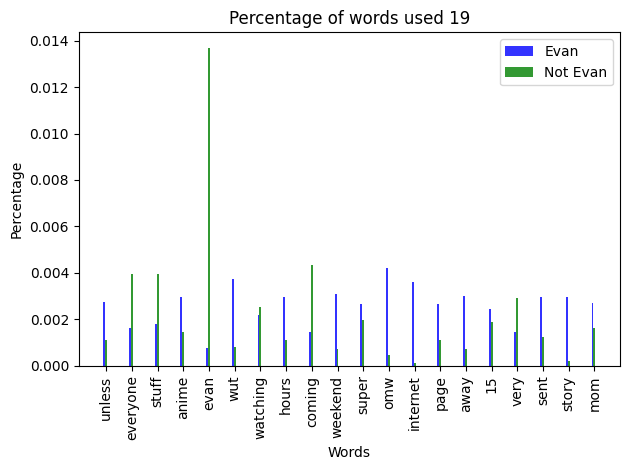

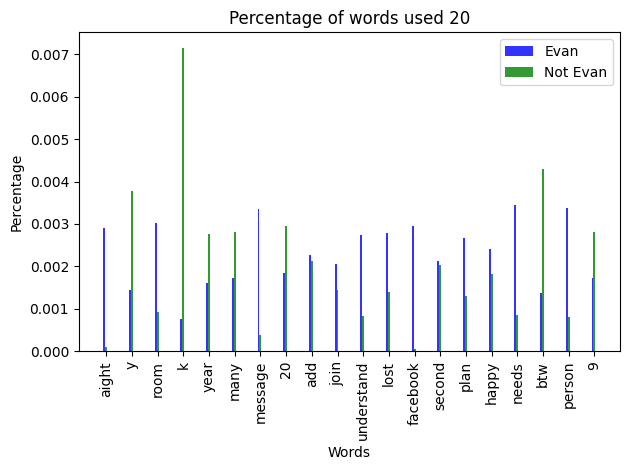

In [11]:
count = 0
for i in range(0,400,20):
    count += 1
    n_groups = 4
    simulacrum = sum(test_X[results==1])[i:i+20]
    simulacrum = [x / len(test_X[results==1]) for x in simulacrum]
    imposter = sum(test_X[results==0])[i:i+20]
    imposter = [x / len(test_X[results==0]) for x in imposter]

    # create plot
    fig, ax = plt.subplots()
    index = np.arange(len(processor.vocabulary[i:i+20]))
    bar_width = .3
    opacity = 0.8

    rects1 = plt.bar(index*4, simulacrum, bar_width,
    alpha=opacity,
    color='b',
    label='Evan')

    rects2 = plt.bar(index*4 + bar_width, imposter, bar_width,
    alpha=opacity,
    color='g',
    label='Not Evan')
    plt.xlabel('Words')
    plt.ylabel('Percentage')
    plt.title('Percentage of words used '+str(count))
    plt.xticks(index*4 + bar_width, (processor.vocabulary[i:i+20]), rotation=90)
    plt.tight_layout()
    plt.legend()
    plt.show()